In [22]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

In [23]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [24]:
dataset, info = tfds.load('imdb_reviews', with_info = True, as_supervised=True) # 영화 리뷰 데이터
train_dataset, test_dataset = dataset['train'], dataset['test']

In [25]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


2023-07-26 15:06:13.942704: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [26]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [27]:
# train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [28]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot devel

2023-07-26 15:06:19.920462: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [29]:
VOCAB_SIZE = 1000
tokenizer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE) # A preprocessing layer which maps text features to integer sequences.
tokenizer.adapt(train_dataset.map(lambda text, label: text))

In [30]:
vocab = np.array(tokenizer.get_vocabulary())
vocab[:20]

# -----------------------------------------------------------------
print(vocab.shape)
print(vocab[:20])

max_length = max(len(s) for s in vocab)
print(max_length)

longest_string = [s for s in vocab if len(s) == max_length][0]
print(longest_string)
# -----------------------------------------------------------------

(1000,)
['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it' 'i' 'this' 'that'
 'br' 'was' 'as' 'for' 'with' 'movie' 'but']
14
cinematography


In [31]:
# -----------------------------------------------------------------
print(example.numpy()[0])
print(example.shape)
# example 에는 64개의 문장이 들어 있었음 ("I am a teacher", "You are a student", ...) 이런 64개 문장
print('---')

max_length = max(tf.strings.length(e) for e in example)
print(max_length) # 4093. 즉 가장 단어가 많은 문장은 총 3480개의 단어로 이루어져 있음
print('---')

tokenized_example = tokenizer(example)
print("tokenzied ex: ", tokenized_example.shape) # (64, 707)
# -----------------------------------------------------------------
# 만약 각 원소가 길이가 3482인 토큰 시퀀스를 가지고 있었다면, tokenizer(example)을 통해 토크나이징된 결과인 tokenized_example의 shape은 (64, 3482)가 되어야 합니다. 각 문장이 3482개의 토큰으로 이루어진 행렬이 되는 것이기 때문입니다.
#
# 하지만 실제로는 tokenized_example의 shape이 (64, 626)인데, 이는 각 문장이 626개의 토큰으로 이루어져 있다는 것을 의미합니다. 이로 인해 tokenized_example의 토큰 개수가 3482보다 적어지게 된 것입니다.
# 
# 이러한 현상이 발생하는 이유는 TextVectorization 레이어가 기본적으로 설정되어 있는 동작 때문입니다. 기본적으로 TextVectorization 레이어는 입력 텍스트를 토큰화한 후 토큰들을 어휘 사전에 매핑하고, 어휘 사전에 없는 토큰들은 무시하고, 존재하는 토큰들만 남겨둡니다.
# 
# 따라서, 토크나이징 결과에서 특정 토큰의 개수가 3482개로 채워지지 않고, 어휘 사전에 존재하는 토큰만 남게 되어서 tokenized_example의 shape이 (64, 626)으로 나타나게 됩니다.
# 
# 이를 해결하기 위해서는 TextVectorization 레이어의 max_tokens 매개변수를 설정하여 어휘 사전의 크기를 제한하거나, output_sequence_length를 조정하여 토큰 시퀀스의 길이를 특정 크기로 맞추는 등의 방법을 사용할 수 있습니다. 자세한 설정 방법은 TextVectorization 레이어의 공식 문서를 참고하시면 됩니다.

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
(64,)
---
tf.Tensor(4093, shape=(), dtype=int32)
---
tokenzied ex:  (64, 707)


In [39]:
# -----------------------------------------------------------------
print(example[0])
print(tf.strings.length(example[0]))
print(tokenized_example[0]) # ?? 왜 2개 줄었지 늘어난게 아니라???
# -----------------------------------------------------------------

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(709, shape=(), dtype=int32)
[ 11  14  34 412 384  18  90  28   1   8  33   1   1  42 487   1 191  24
  85 152  19  11 217 316  28  65 240 214   8 489  54  65  85 112  96  22
   1  11  93 642 743  11  18   7  34 394   1 170   1 408   2  88   1

In [38]:

tokenized_example = tokenizer(example)[:3].numpy()
tokenized_example

array([[11, 14, 34, ...,  0,  0,  0],
       [10, 26, 75, ...,  0,  0,  0],
       [ 1,  1,  2, ...,  0,  0,  0]])

In [40]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[tokenized_example[n]])) # 즉 tokenized_example 에는 index 가 들어있음
  print()

Original:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Round-trip:  this was an absolutely terrible movie dont be [UNK] in by [UNK] [UNK] or michael [UNK] both are great actors but this must simply be their worst role in history even their great acting could not [UNK] this movies ridiculous storyline this movie is an early [UNK] 

In [41]:
model = tf.keras.Sequential([
    tokenizer,
    tf.keras.layers.Embedding(
        input_dim=len(tokenizer.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.LSTM(64),  # Unidirectional LSTM
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [42]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [43]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 551ms/step
[-0.01949192]


In [44]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 24ms/step
[-0.01949192]


In [45]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [46]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 19s 44ms/step - loss: 0.6468 - accuracy: 0.5497 - val_loss: 0.5014 - val_accuracy: 0.7599
Epoch 2/10
  6/391 [..............................] - ETA: 9s - loss: 0.4911 - accuracy: 0.7786 

2023-07-26 15:08:00.970058: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 12s 30ms/step - loss: 0.4100 - accuracy: 0.8181 - val_loss: 0.3655 - val_accuracy: 0.8443
Epoch 3/10
  5/391 [..............................] - ETA: 10s - loss: 0.3260 - accuracy: 0.8687

2023-07-26 15:08:12.783115: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 12s 30ms/step - loss: 0.3456 - accuracy: 0.8528 - val_loss: 0.3466 - val_accuracy: 0.8500
Epoch 4/10
  6/391 [..............................] - ETA: 9s - loss: 0.3188 - accuracy: 0.8802 

2023-07-26 15:08:24.629183: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 12s 30ms/step - loss: 0.3273 - accuracy: 0.8615 - val_loss: 0.3415 - val_accuracy: 0.8562
Epoch 5/10
  5/391 [..............................] - ETA: 10s - loss: 0.2993 - accuracy: 0.8938

2023-07-26 15:08:36.296929: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 12s 30ms/step - loss: 0.3185 - accuracy: 0.8679 - val_loss: 0.3426 - val_accuracy: 0.8542
Epoch 6/10
  5/391 [..............................] - ETA: 10s - loss: 0.3024 - accuracy: 0.8844

2023-07-26 15:08:47.979395: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 12s 30ms/step - loss: 0.3153 - accuracy: 0.8691 - val_loss: 0.3403 - val_accuracy: 0.8583
Epoch 7/10
  5/391 [..............................] - ETA: 10s - loss: 0.2958 - accuracy: 0.8844

2023-07-26 15:08:59.892586: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 12s 30ms/step - loss: 0.3105 - accuracy: 0.8721 - val_loss: 0.3377 - val_accuracy: 0.8573
Epoch 8/10
  6/391 [..............................] - ETA: 9s - loss: 0.3056 - accuracy: 0.8828 

2023-07-26 15:09:11.732697: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 12s 30ms/step - loss: 0.3089 - accuracy: 0.8730 - val_loss: 0.3361 - val_accuracy: 0.8573
Epoch 9/10
  5/391 [..............................] - ETA: 10s - loss: 0.2882 - accuracy: 0.8969

2023-07-26 15:09:23.520564: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 12s 30ms/step - loss: 0.3078 - accuracy: 0.8734 - val_loss: 0.3347 - val_accuracy: 0.8620
Epoch 10/10
  6/391 [..............................] - ETA: 9s - loss: 0.3007 - accuracy: 0.8906 

2023-07-26 15:09:35.441905: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 12s 30ms/step - loss: 0.3051 - accuracy: 0.8749 - val_loss: 0.3339 - val_accuracy: 0.8615


2023-07-26 15:09:47.290396: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [47]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 6s 15ms/step - loss: 0.3238 - accuracy: 0.8615
Test Loss: 0.32383427023887634
Test Accuracy: 0.8614799976348877


(0.0, 0.6639177352190018)

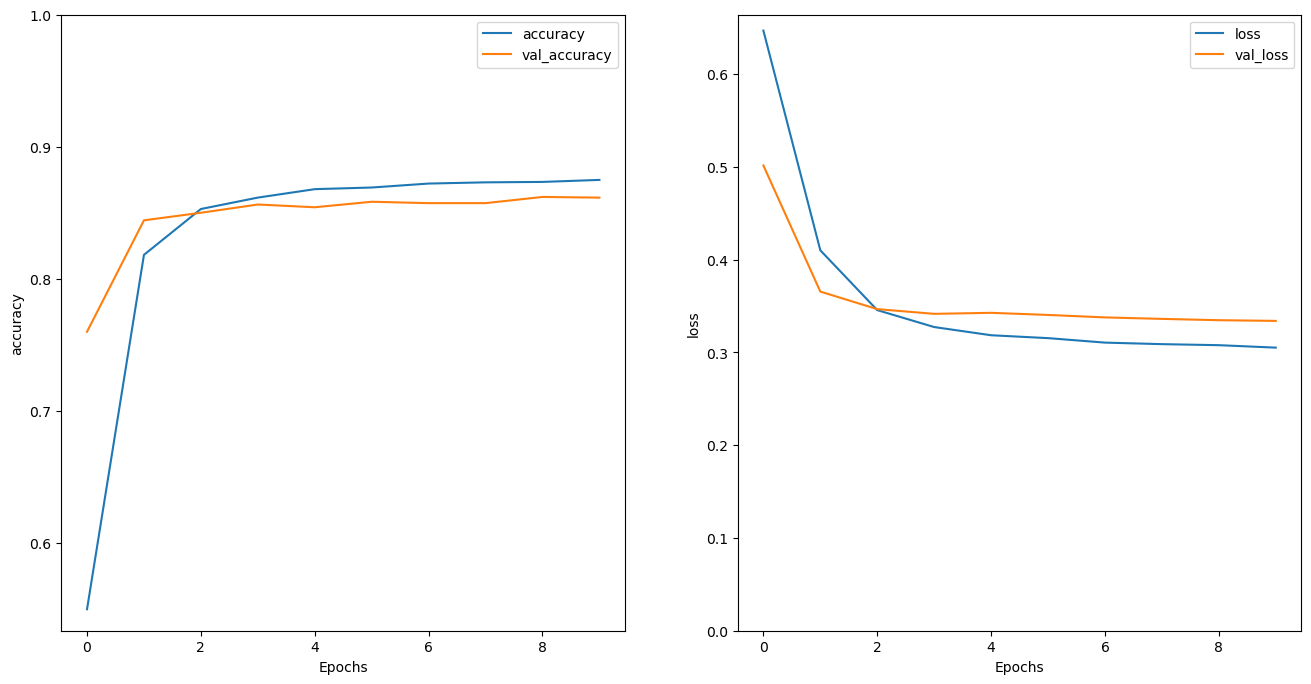

In [48]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [49]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 1s 706ms/step
[[0.5561876]]
